In [ ]:
%pip install tensorflow
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# Load data
df = pd.read_csv('BTC-USD.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[['Close']]

# Function to create windowed dataset
def create_windowed_dataset(data, n=3):
    X, Y = [], []
    for i in range(len(data)-n-1):
        X.append(data[i:i+n])
        Y.append(data[i+n])
    return np.array(X), np.array(Y)

# Prepare data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

X, y = create_windowed_dataset(scaled_data)

# Split data into train, validation, and test sets
# Split data into train, validation, and test sets
q_80 = int(len(df) * 0.8)
q_90 = int(len(df) * 0.9)

dates_train, X_train, y_train = df.index[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = df.index[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = df.index[q_90:], X[q_90:], y[q_90:]


# Define DNN model
model_dnn = Sequential([
    layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


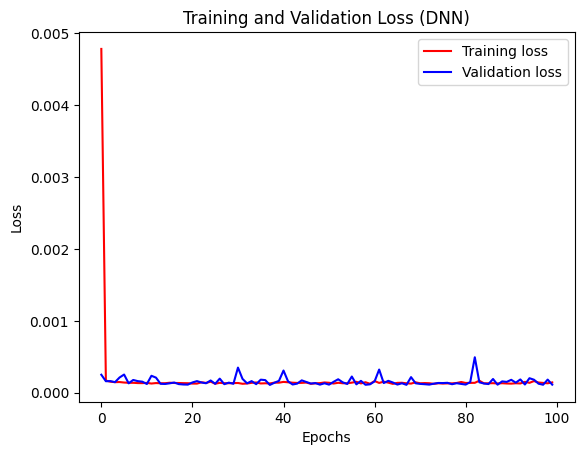

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:
# Compile the model
model_dnn.compile(optimizer='adam', loss='mse')

# Train the model
history_dnn = model_dnn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=0)

# Plot training and validation loss
loss_dnn = history_dnn.history['loss']
val_loss_dnn = history_dnn.history['val_loss']

epochs_dnn = range(len(loss_dnn))

plt.plot(epochs_dnn, loss_dnn, 'r', label='Training loss')
plt.plot(epochs_dnn, val_loss_dnn, 'b', label='Validation loss')
plt.title('Training and Validation Loss (DNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predictions
train_predictions_dnn = model_dnn.predict(X_train).flatten()
test_predictions_dnn = model_dnn.predict(X_test).flatten()


In [ ]:
# Inverse transform predictions
train_predictions_dnn = scaler.inverse_transform(train_predictions_dnn.reshape(-1, 1)).flatten()
test_predictions_dnn = scaler.inverse_transform(test_predictions_dnn.reshape(-1, 1)).flatten()

# Inverse transform original data
original_ytrain = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
original_ytest = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluate the model
print("Train data RMSE (DNN):", math.sqrt(mean_squared_error(original_ytrain, train_predictions_dnn)))
print("Test data RMSE (DNN):", math.sqrt(mean_squared_error(original_ytest, test_predictions_dnn)))
print("Train data MSE (DNN):", mean_squared_error(original_ytrain, train_predictions_dnn))
print("Test data MSE (DNN):", mean_squared_error(original_ytest, test_predictions_dnn))
print("Train data MAE (DNN):", mean_absolute_error(original_ytrain, train_predictions_dnn))
print("Test data MAE (DNN):", mean_absolute_error(original_ytest, test_predictions_dnn))
print("Train data explained variance regression score (DNN):", explained_variance_score(original_ytrain, train_predictions_dnn))
print("Test data explained variance regression score (DNN):", explained_variance_score(original_ytest, test_predictions_dnn))


Train data RMSE (DNN): 817.8517702706749
Test data RMSE (DNN): 1080.9886943319584
Train data MSE (DNN): 668881.5181348769
Test data MSE (DNN): 1168536.5572735122
Train data MAE (DNN): 372.4551782071888
Test data MAE (DNN): 656.0931236610786
Train data explained variance regression score (DNN): 0.997617691263233
Test data explained variance regression score (DNN): 0.9906208565885808


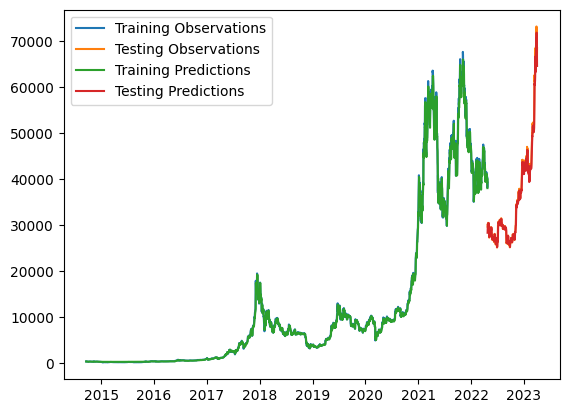

In [ ]:
# Plot predictions
plt.plot(df.index[:len(original_ytrain)], original_ytrain, label='Training Observations')
plt.plot(df.index[len(original_ytrain):len(original_ytrain) + len(original_ytest)], original_ytest, label='Testing Observations')
plt.plot(df.index[:len(original_ytrain)], train_predictions_dnn, label='Training Predictions')
# Adjust the x-values for test predictions to match the corresponding dates
plt.plot(df.index[len(original_ytrain):len(original_ytrain) + len(test_predictions_dnn)], test_predictions_dnn, label='Testing Predictions')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
from tabulate import tabulate

# Create a dictionary to store the data
data = {
    'Model': ['SuSi', 'DNN', 'LSTM', 'RNN'],
    'RMSE': [1160.8130, 1078.777, 1170.689, 1145.131],
    'R² Score': [0.99508, 0.99081, 0.99696, 0.99313],
    'R² Score Range': ['99.1 - 99.5', '99.0 - 99.3', '99.1 - 99.6', '99.1 - 99.3'],
    'Before 3-day R² Score': [0.8346, 0.8121, 0.8641, 0.85],
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Set the 'Model' column as the index
df.set_index('Model', inplace=True)

# Convert DataFrame to ASCII table using tabulate
table = tabulate(df, headers='keys', tablefmt='pipe')

# Print the table
print(table)

from prettytable import PrettyTable

# Create the table
table = PrettyTable()
table.field_names = df.columns

# Add rows from DataFrame
for index, row in df.iterrows():
    table.add_row(row.tolist())

# Print the table with actual lines (default behavior)
print(table)


| Model   |    RMSE |   R² Score | R² Score Range   |   Before 3-day R² Score |
|:--------|--------:|-----------:|:-----------------|------------------------:|
| SuSi    | 1160.81 |    0.99508 | 99.1 - 99.5      |                  0.8346 |
| DNN     | 1078.78 |    0.99081 | 99.0 - 99.3      |                  0.8121 |
| LSTM    | 1170.69 |    0.99696 | 99.1 - 99.6      |                  0.8641 |
| RNN     | 1145.13 |    0.99313 | 99.1 - 99.3      |                  0.85   |
+----------+----------+----------------+-----------------------+
|   RMSE   | R² Score | R² Score Range | Before 3-day R² Score |
+----------+----------+----------------+-----------------------+
| 1160.813 | 0.99508  |  99.1 - 99.5   |         0.8346        |
| 1078.777 | 0.99081  |  99.0 - 99.3   |         0.8121        |
| 1170.689 | 0.99696  |  99.1 - 99.6   |         0.8641        |
| 1145.131 | 0.99313  |  99.1 - 99.3   |          0.85         |
+----------+----------+----------------+-----------------------+
